# MNIST

This notebook contains our experiements comparing forward gradient and backpropagation with neural networks and Convolutional nets for the MNIST dataset

#### Setup

In [1]:
# Run once
# CPU only: !pip install torch==1.11.0 torchvision==0.12.0 torchaudio==0.11.0 -f https://download.pytorch.org/whl/cpu/torch_stable.html
!pip install --pre torch -f https://download.pytorch.org/whl/nightly/cpu/torch_nightly.html --upgrade
!pip install functorch
print("--> Restarting colab instance") 
get_ipython().kernel.do_shutdown(True)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.pytorch.org/whl/nightly/cpu/torch_nightly.html
     |████████████████████████████████| 190.8 MB 75 kB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.11.0+cu113
    Uninstalling torch-1.11.0+cu113:
      Successfully uninstalled torch-1.11.0+cu113
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.12.0+cu113 requires torch==1.11.0, but you have torch 1.13.0.dev20220612+cpu which is incompatible.
torchtext 0.12.0 requires torch==1.11.0, but you have torch 1.13.0.dev20220612+cpu which is incompatible.
torchaudio 0.11.0+cu113 requires torch==1.11.0, but you have torch 1.13.0.dev20220612+cpu which is incompatible.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/

{'restart': True, 'status': 'ok'}

In [1]:
!git clone https://github.com/benjaminrike1/forward_gradient

Cloning into 'forward_gradient'...
remote: Enumerating objects: 96, done.
remote: Counting objects: 100% (96/96), done.
remote: Compressing objects: 100% (71/71), done.
remote: Total 96 (delta 44), reused 66 (delta 24), pack-reused 0
Unpacking objects: 100% (96/96), done.


In [1]:
cd forward_gradient

/content/forward_gradient


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
import functorch as ft

import numpy as np
from functools import partial

import matplotlib.pyplot as plt
import seaborn as sns

from loss import functional_xent, softmax, clamp_probs, _xent
from optimizers import ForwardSGD, ForwardAdam
from models import Net, ConvNet, LogisticRegression

torch.manual_seed(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


/usr/local/lib/python3.7/dist-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


## MNIST

Importing the data from torchvision.

In [3]:
# transforming images to tensors
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()
])


mnist_train = torchvision.datasets.MNIST(
    '/tmp/data',
    train=True, 
    download=True, 
    transform=transform
)

# splitting into training and validation set
train, val = torch.utils.data.random_split(mnist_train, [50000, 10000])

train_data_loader = torch.utils.data.DataLoader(train, 
                                          batch_size=64, 
                                          shuffle=True)

val_data_loader = torch.utils.data.DataLoader(val, 
                                          batch_size=64, 
                                          shuffle=True)

# loading test set
mnist_test = torchvision.datasets.MNIST(
    '/tmp/data',
    train=False, 
    download=True, 
    transform=transform
)
test_data_loader = torch.utils.data.DataLoader(mnist_test, 
                                              batch_size=64,
                                              shuffle=True)

# Neural Network

We first use a vanilla feedforward network for the optimization. The net can be found in `models.py`

## SGD

### Learning rate optimization

The final search for learning rate is in a quite small interval as we earlier tried a wider search, but wanted to reduce the width to find a better optimum.

Searching for best learning rate and learning rate decay for forward gradient.

In [4]:
torch.manual_seed(42) # setting seed for reproducibility

# learning rate and decays grid search for forward gradient
learning_rates = np.logspace(-4, -3, 4)
decays = np.append(np.logspace(-6, -5, 2), 0)

epochs = 10

for gamma in learning_rates:
  for lambda_ in decays:
    net = Net().to(device) # defining net

    # making the net functional to run the code in functorch
    # for evaluating the Jacobian-vector product
    func, params = ft.make_functional(net)

    # removing requires gradient as it will not be used
    # for the forward AD
    for param in params:
        param.requires_grad_(False)

    # defining our optimizer
    opt = ForwardSGD(func, functional_xent, params, lr=gamma, momentum = False, decay=lambda_)

    # training
    for e in range(epochs):
      for i, (image, label) in enumerate(train_data_loader):
        image, label = image.to(device), label.to(device)
        params, loss, jvp = opt.step(image, label) # one optimization step

    # evaluating on the val set
    test_losses = []
    for i, (image, label) in enumerate(val_data_loader):
      batch_loss = []
      with torch.no_grad():
        image, label = image.to(device), label.to(device)
        val_loss = functional_xent(params, func,image, label)
        batch_loss.append(val_loss.item())
      test_losses.append(np.mean(batch_loss))
    print(f"Validation loss for lr = {format(gamma,'.6f')}, decay = {format(lambda_,'.6f')}: {format(np.mean(test_losses),'.3f')}")

Validation loss for lr = 0.000100, decay = 0.000001: 2.251
Validation loss for lr = 0.000100, decay = 0.000010: 2.242
Validation loss for lr = 0.000100, decay = 0.000000: 2.249
Validation loss for lr = 0.000215, decay = 0.000001: 2.141
Validation loss for lr = 0.000215, decay = 0.000010: 2.141
Validation loss for lr = 0.000215, decay = 0.000000: 2.140
Validation loss for lr = 0.000464, decay = 0.000001: 11.586
Validation loss for lr = 0.000464, decay = 0.000010: 1.126
Validation loss for lr = 0.000464, decay = 0.000000: 1.562
Validation loss for lr = 0.001000, decay = 0.000001: 14.514
Validation loss for lr = 0.001000, decay = 0.000010: 14.127
Validation loss for lr = 0.001000, decay = 0.000000: 13.713


Searching for best learning rate and learning rate decay for backpropagation.

In [5]:
torch.manual_seed(42) # setting seed for reporducibility

# defining learning rates and decays for grid search
learning_rates = np.logspace(-3, -1, 4)
decays = np.append(np.logspace(-6, -5, 2), 0)

criterion = nn.CrossEntropyLoss() # loss function
for gamma in learning_rates:
  for lambda_ in decays:
    lr_new = gamma
    net = Net().to(device) # defining net

    # storing losses
    losses = []
    steps = 0
    for epoch in range(epochs):
      # going over training set in batches
      for i, (image, label) in enumerate(train_data_loader):
        steps += 1
        backprop = torch.optim.SGD(net.parameters(), lr=lr_new) # backprop SGD
        image, label = image.to(device), label.to(device)

        # optimizing
        backprop.zero_grad()
        outputs = net(image)
        loss = criterion(outputs, label)
        loss.backward()
        backprop.step()
        losses.append(loss.item())

        # learning rate decay
        lr_new = gamma * np.exp(-steps*lambda_)

    # evaluating on the val set
    test_losses = []
    for i, (image, label) in enumerate(val_data_loader):
      batch_loss = []
      with torch.no_grad():
        image, label = image.to(device), label.to(device)
        val_loss = criterion(net(image), label)
        batch_loss.append(val_loss.item())
      test_losses.append(np.mean(batch_loss))
    print(f"Validation loss for lr = {format(gamma,'.6f')}, decay = {format(lambda_,'.6f')}: {format(np.mean(test_losses),'.3f')}")

Validation loss for lr = 0.001000, decay = 0.000001: 0.742
Validation loss for lr = 0.001000, decay = 0.000010: 0.737
Validation loss for lr = 0.001000, decay = 0.000000: 0.745
Validation loss for lr = 0.004642, decay = 0.000001: 0.310
Validation loss for lr = 0.004642, decay = 0.000010: 0.312
Validation loss for lr = 0.004642, decay = 0.000000: 0.304
Validation loss for lr = 0.021544, decay = 0.000001: 0.150
Validation loss for lr = 0.021544, decay = 0.000010: 0.148
Validation loss for lr = 0.021544, decay = 0.000000: 0.149
Validation loss for lr = 0.100000, decay = 0.000001: 0.071
Validation loss for lr = 0.100000, decay = 0.000010: 0.079
Validation loss for lr = 0.100000, decay = 0.000000: 0.070


### Modeling

We first run forward gradient for the optimal hyperparameters.

In [6]:
# for reproducible purposes
torch.manual_seed(42)

net = Net().to(device) # defining net

# using best lr and decay found in the optimizations below
lr = 0.000464
decay = 1e-5
# making the net functional to run the code in functorch
# for evaluating the Jacobian-vector product
func, params = ft.make_functional(net)

# removing requires gradient as it will not be used
# for the forward AD
for param in params:
    param.requires_grad_(False)

# defining our optimizer
opt = ForwardSGD(func, functional_xent, params, lr=lr, momentum = False, decay=decay)

# running the code for e epochs
losses_fwd = []
norms = []
epochs = 25
test_losses_fwd = []
for e in range(epochs):
  # training
  for j, (image, label) in enumerate(train_data_loader):
    image, label = image.to(device), label.to(device)
    params, loss, norm = opt.step(image, label)
    try:
      norms.append(np.abs(norm.item()))
    except:
      norms.append(np.abs(norm))
    losses_fwd.append(loss.item())
  # evaluating on the test set
  for i, (image, label) in enumerate(test_data_loader):
    with torch.no_grad():
      batch_loss = []
      image, label = image.to(device), label.to(device)
      test_loss = functional_xent(params, func, image, label)
      batch_loss.append(test_loss.item())
  test_losses_fwd.append(np.mean(batch_loss))
  print(f"Test loss in epoch {e+1}: {(test_losses_fwd[-1])}")


Test loss in epoch 1: 2.276754379272461
Test loss in epoch 2: 2.229856491088867
Test loss in epoch 3: 2.245063066482544
Test loss in epoch 4: 2.1505117416381836
Test loss in epoch 5: 2.007540225982666
Test loss in epoch 6: 1.9714754819869995
Test loss in epoch 7: 1.8052902221679688
Test loss in epoch 8: 1.4845551252365112
Test loss in epoch 9: 1.513105869293213
Test loss in epoch 10: 0.7407682538032532
Test loss in epoch 11: 1.9370222091674805
Test loss in epoch 12: 12.953187942504883
Test loss in epoch 13: 13.771442413330078
Test loss in epoch 14: 14.945985794067383
Test loss in epoch 15: 10.55512809753418
Test loss in epoch 16: 12.953187942504883
Test loss in epoch 17: 12.953187942504883
Test loss in epoch 18: 15.942384719848633
Test loss in epoch 19: 12.953187942504883
Test loss in epoch 20: 14.945985794067383
Test loss in epoch 21: 10.960390090942383
Test loss in epoch 22: 10.960390090942383
Test loss in epoch 23: 14.945985794067383
Test loss in epoch 24: 13.949586868286133
Test lo

Text(0.5, 1.0, 'Jacobian vector norm per iteration')

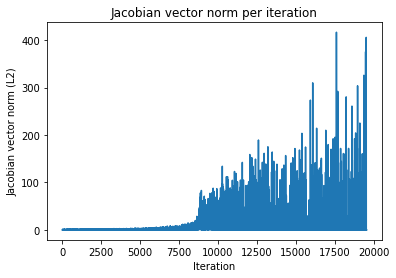

In [7]:
plt.plot(norms)
plt.xlabel("Iteration")
plt.ylabel("Jacobian vector norm (L2)")
plt.title("Jacobian vector norm per iteration")

In [8]:
print(np.max(norms[:10000])); print(np.max(norms)); print(np.max(norms[:11000]))
print(np.mean(norms[:10000]))
print(np.std(norms[:10000]))

87.86993408203125
416.6250915527344
134.16180419921875
3.340167948278336
7.877840072580223


As can be seen, we deal with exploding gradients. To mitigate this, we utilize gradient clipping. Specifically, we impose that the norm of the Jacobian vector product must be less than 1.

In [9]:
torch.manual_seed(42) # setting seed for reproducibility

net = Net().to(device) # defining net

# using best lr and decay found in the optimizations below
lr = 0.000464
decay = 1e-5
# making the net functional to run the code in functorch
# for evaluating the Jacobian-vector product
func, params = ft.make_functional(net)

# removing requires gradient as it will not be used
# for the forward AD
for param in params:
    param.requires_grad_(False)

# defining our optimizer
opt = ForwardSGD(func, functional_xent, params, lr=lr, momentum = False, decay=decay, clip = 1)

# training for e epochs
losses_fwd = []
norms = []
epochs = 50
test_losses_fwd = []
for e in range(epochs):
  for j, (image, label) in enumerate(train_data_loader):
    image, label = image.to(device), label.to(device)
    params, loss, norm = opt.step(image, label)
    try:
      norms.append(norm.item())
    except:
      norms.append(norm)
    losses_fwd.append(loss.item())

  # evaluating on the test set
  for i, (image, label) in enumerate(test_data_loader):
    with torch.no_grad():
      batch_loss = []
      image, label = image.to(device), label.to(device)
      test_loss = functional_xent(params, func, image, label)
      batch_loss.append(test_loss.item())
  test_losses_fwd.append(np.mean(batch_loss))
  print(f"Test loss in epoch {e+1}: {format(test_losses_fwd[-1], '.3f')}")


Test loss in epoch 1: 2.276
Test loss in epoch 2: 2.231
Test loss in epoch 3: 2.251
Test loss in epoch 4: 2.168
Test loss in epoch 5: 2.067
Test loss in epoch 6: 2.077
Test loss in epoch 7: 1.972
Test loss in epoch 8: 1.864
Test loss in epoch 9: 1.827
Test loss in epoch 10: 1.727
Test loss in epoch 11: 1.633
Test loss in epoch 12: 1.595
Test loss in epoch 13: 1.352
Test loss in epoch 14: 1.484
Test loss in epoch 15: 1.221
Test loss in epoch 16: 1.196
Test loss in epoch 17: 1.058
Test loss in epoch 18: 1.439
Test loss in epoch 19: 0.909
Test loss in epoch 20: 0.928
Test loss in epoch 21: 0.734
Test loss in epoch 22: 0.572
Test loss in epoch 23: 1.564
Test loss in epoch 24: 0.655
Test loss in epoch 25: 0.538
Test loss in epoch 26: 0.617
Test loss in epoch 27: 0.857
Test loss in epoch 28: 0.624
Test loss in epoch 29: 0.566
Test loss in epoch 30: 0.486
Test loss in epoch 31: 0.551
Test loss in epoch 32: 0.589
Test loss in epoch 33: 0.572
Test loss in epoch 34: 0.400
Test loss in epoch 35: 

Backpropagation:

In [10]:
torch.manual_seed(42) # setting seed for reproducibility

lr = 0.100000
decay = 0
epochs = 50
lr_new = lr
criterion = nn.CrossEntropyLoss() # loss function
net = Net().to(device) # defining net

# storing losses
losses = []
test_losses = []
steps = 0
for e in range(epochs):
  # going over training set in batches
  for i, (image, label) in enumerate(train_data_loader):
    steps += 1
    backprop = torch.optim.SGD(net.parameters(), lr=lr_new) # normal SGD in torch
    image, label = image.to(device), label.to(device)
    backprop.zero_grad()
    outputs = net(image)
    loss = criterion(outputs, label)
    loss.backward()
    backprop.step()
    losses.append(loss.item())
    lr_new = lr * np.exp(-steps*decay)
  
  # testing on test set
  for i, (image, label) in enumerate(test_data_loader):
    with torch.no_grad():
      batch_loss = []
      image, label = image.to(device), label.to(device)
      test_loss = criterion(net(image), label)
      batch_loss.append(test_loss.item())
  test_losses.append(np.mean(batch_loss))
  print(f"Test loss in epoch {e+1}: {(test_losses[-1])}")

Test loss in epoch 1: 0.21089600026607513
Test loss in epoch 2: 0.018330974504351616
Test loss in epoch 3: 0.043267495930194855
Test loss in epoch 4: 0.09450326859951019
Test loss in epoch 5: 0.053974270820617676
Test loss in epoch 6: 0.0013429009122774005
Test loss in epoch 7: 0.0017417690251022577
Test loss in epoch 8: 0.12855468690395355
Test loss in epoch 9: 0.003445312613621354
Test loss in epoch 10: 0.0485224723815918
Test loss in epoch 11: 0.0038545248098671436
Test loss in epoch 12: 0.017548387870192528
Test loss in epoch 13: 0.005903841461986303
Test loss in epoch 14: 0.1460621953010559
Test loss in epoch 15: 0.0064318617805838585
Test loss in epoch 16: 0.12599988281726837
Test loss in epoch 17: 0.005304242949932814
Test loss in epoch 18: 0.38441839814186096
Test loss in epoch 19: 0.01203002780675888
Test loss in epoch 20: 0.003206605091691017
Test loss in epoch 21: 0.272867888212204
Test loss in epoch 22: 0.0017718407325446606
Test loss in epoch 23: 0.6106453537940979
Test lo

#### Comparing results

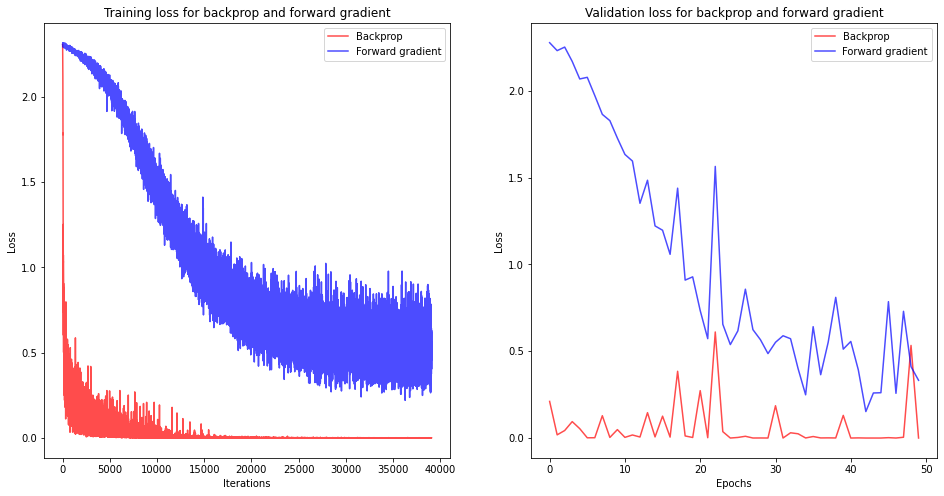

In [11]:
fig, ax = plt.subplots(1,2,figsize=(16,8))

ax[0].plot(losses, color='r', label="Backprop", alpha=.7)
ax[0].set_xlabel("Iterations")
ax[0].set_ylabel("Loss")
ax[0].plot(losses_fwd[:], color='b', label='Forward gradient', alpha=.7)
ax[0].set_title("Training loss for backprop and forward gradient")
ax[0].legend()

ax[1].plot(test_losses, color='r', label="Backprop", alpha=.7)
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
ax[1].plot(test_losses_fwd, color='b', label='Forward gradient', alpha=.7)
ax[1].set_title("Test loss for backprop and forward gradient")
ax[1].legend()

## SGD with Nesterov momentum

We now incorporate SGD with Nesterov momentum.

### Learning rate optimization

The final search for learning rate is in a quite small interval as we earlier tried a wider search, but wanted to reduce the width to find a better optimum.

Searching for best learning rate and momentum for forward gradient.

In [4]:
torch.manual_seed(42) # setting seed for reproducibility

# learning rate and momentum grid search for forward gradient
learning_rates = np.logspace(-4, -3, 4)
momentums = np.linspace(0.1, 0.9, 4)

epochs = 10

for gamma in learning_rates:
  for momentum in momentums:
    net = Net().to(device) # defining net

    # making the net functional to run the code in functorch
    # for evaluating the Jacobian-vector product
    func, params = ft.make_functional(net)

    # removing requires gradient as it will not be used
    # for the forward AD
    for param in params:
        param.requires_grad_(False)

    # defining our optimizer
    opt = ForwardSGD(func, functional_xent, params, lr=gamma,
                     momentum = momentum, nesterov = True, decay=0, clip=1)

    # training
    for e in range(epochs):
      for i, (image, label) in enumerate(train_data_loader):
        image, label = image.to(device), label.to(device)
        params, loss, jvp = opt.step(image, label) # one optimization step

    # evaluating on the val set
    test_losses = []
    for i, (image, label) in enumerate(val_data_loader):
      batch_loss = []
      with torch.no_grad():
        image, label = image.to(device), label.to(device)
        val_loss = functional_xent(params, func,image, label)
        batch_loss.append(val_loss.item())
      test_losses.append(np.mean(batch_loss))
    print(f"Validation loss for lr = {format(gamma,'.5f')}, momentum = {format(momentum,'.3f')}: {format(np.mean(test_losses),'.3f')}")

Validation loss for lr = 0.00010, momentum = 0.100: 2.246
Validation loss for lr = 0.00010, momentum = 0.367: 2.201
Validation loss for lr = 0.00010, momentum = 0.633: 2.088
Validation loss for lr = 0.00010, momentum = 0.900: 0.850
Validation loss for lr = 0.00022, momentum = 0.100: 2.126
Validation loss for lr = 0.00022, momentum = 0.367: 1.958
Validation loss for lr = 0.00022, momentum = 0.633: 1.341
Validation loss for lr = 0.00022, momentum = 0.900: 4.585
Validation loss for lr = 0.00046, momentum = 0.100: 1.542
Validation loss for lr = 0.00046, momentum = 0.367: 1.005
Validation loss for lr = 0.00046, momentum = 0.633: 1.332
Validation loss for lr = 0.00046, momentum = 0.900: 10.618
Validation loss for lr = 0.00100, momentum = 0.100: 1.007
Validation loss for lr = 0.00100, momentum = 0.367: 2.318
Validation loss for lr = 0.00100, momentum = 0.633: 6.078
Validation loss for lr = 0.00100, momentum = 0.900: 12.087


Searching for best learning rate and momentum for backpropagation.

In [7]:
torch.manual_seed(42) # setting seed for reporducibility

# defining learning rates and decays for grid search
learning_rates = np.logspace(-3, -1, 4)
momentums = np.linspace(0.5, 0.9, 4)

criterion = nn.CrossEntropyLoss() # loss function
for gamma in learning_rates:
  for momentum in momentums:
    net = Net().to(device) # defining net
    backprop = torch.optim.SGD(net.parameters(), lr=gamma,
                                   momentum = momentum, nesterov = True) # backprop SGD

    # storing losses
    losses = []
    for epoch in range(epochs):
      # going over training set in batches
      for i, (image, label) in enumerate(train_data_loader):
        image, label = image.to(device), label.to(device)

        # optimizing
        backprop.zero_grad()
        outputs = net(image)
        loss = criterion(outputs, label)
        loss.backward()
        backprop.step()
        losses.append(loss.item())

    # evaluating on the val set
    test_losses = []
    for i, (image, label) in enumerate(val_data_loader):
      batch_loss = []
      with torch.no_grad():
        image, label = image.to(device), label.to(device)
        val_loss = criterion(net(image), label)
        batch_loss.append(val_loss.item())
      test_losses.append(np.mean(batch_loss))
    print(f"Validation loss for lr = {format(gamma,'.4f')}, momentum = {format(momentum,'.3f')}: {format(np.mean(test_losses),'.3f')}")

Validation loss for lr = 0.0010, momentum = 0.500: 0.432
Validation loss for lr = 0.0010, momentum = 0.633: 0.367
Validation loss for lr = 0.0010, momentum = 0.767: 0.317
Validation loss for lr = 0.0010, momentum = 0.900: 0.230
Validation loss for lr = 0.0046, momentum = 0.500: 0.237
Validation loss for lr = 0.0046, momentum = 0.633: 0.201
Validation loss for lr = 0.0046, momentum = 0.767: 0.157
Validation loss for lr = 0.0046, momentum = 0.900: 0.088
Validation loss for lr = 0.0215, momentum = 0.500: 0.100
Validation loss for lr = 0.0215, momentum = 0.633: 0.085
Validation loss for lr = 0.0215, momentum = 0.767: 0.075
Validation loss for lr = 0.0215, momentum = 0.900: 0.070
Validation loss for lr = 0.1000, momentum = 0.500: 0.068
Validation loss for lr = 0.1000, momentum = 0.633: 0.077
Validation loss for lr = 0.1000, momentum = 0.767: 0.073
Validation loss for lr = 0.1000, momentum = 0.900: 0.114


### Modeling

We first run forward gradient for the optimal hyperparameters.

In [13]:
# for reproducible purposes
torch.manual_seed(42)

net = Net().to(device) # defining net

# using best lr and decay found in the optimizations below
lr = 0.0010
momentum = 0.100
# making the net functional to run the code in functorch
# for evaluating the Jacobian-vector product
func, params = ft.make_functional(net)

# removing requires gradient as it will not be used
# for the forward AD
for param in params:
    param.requires_grad_(False)

# defining our optimizer
opt = ForwardSGD(func, functional_xent, params, lr=lr, momentum = momentum, nesterov = True, clip = 1)

# running the code for e epochs
losses_fwd = []
epochs = 50
test_losses_fwd = []
for e in range(epochs):
  # training
  for j, (image, label) in enumerate(train_data_loader):
    image, label = image.to(device), label.to(device)
    params, loss, jvp = opt.step(image, label)
    losses_fwd.append(loss.item())
  # evaluating on the test set
  for i, (image, label) in enumerate(test_data_loader):
    with torch.no_grad():
      batch_loss = []
      image, label = image.to(device), label.to(device)
      test_loss = functional_xent(params, func, image, label)
      batch_loss.append(test_loss.item())
  test_losses_fwd.append(np.mean(batch_loss))
  print(f"Test loss in epoch {e+1}: {(test_losses_fwd[-1])}")


Test loss in epoch 1: 2.216801881790161
Test loss in epoch 2: 2.031440258026123
Test loss in epoch 3: 1.8496930599212646
Test loss in epoch 4: 1.397027611732483
Test loss in epoch 5: 1.0669891834259033
Test loss in epoch 6: 0.7267148494720459
Test loss in epoch 7: 0.6018703579902649
Test loss in epoch 8: 0.8449952602386475
Test loss in epoch 9: 0.9118472337722778
Test loss in epoch 10: 1.1807867288589478
Test loss in epoch 11: 1.665630578994751
Test loss in epoch 12: 1.0540037155151367
Test loss in epoch 13: 1.056373119354248
Test loss in epoch 14: 2.9946846961975098
Test loss in epoch 15: 1.7153407335281372
Test loss in epoch 16: 1.2769749164581299
Test loss in epoch 17: 1.1939730644226074
Test loss in epoch 18: 3.3517301082611084
Test loss in epoch 19: 1.6443243026733398
Test loss in epoch 20: 2.147191286087036
Test loss in epoch 21: 2.6215574741363525
Test loss in epoch 22: 1.6366945505142212
Test loss in epoch 23: 4.838977336883545
Test loss in epoch 24: 1.4220160245895386
Test los

Backpropagation:

In [6]:
torch.manual_seed(42) # setting seed for reproducibility

lr = 0.1
momentum = 0.500
epochs = 50
lr_new = lr
criterion = nn.CrossEntropyLoss() # loss function
net = Net().to(device) # defining net
backprop = torch.optim.SGD(net.parameters(), lr=lr_new,
                               momentum = momentum, nesterov = True) # normal SGD in torch

# storing losses
losses = []
test_losses = []
for e in range(epochs):
  # going over training set in batches
  for i, (image, label) in enumerate(train_data_loader):
    image, label = image.to(device), label.to(device)
    backprop.zero_grad()
    outputs = net(image)
    loss = criterion(outputs, label)
    loss.backward()
    backprop.step()
    losses.append(loss.item())
  
  # testing on test set
  for i, (image, label) in enumerate(test_data_loader):
    with torch.no_grad():
      batch_loss = []
      image, label = image.to(device), label.to(device)
      test_loss = criterion(net(image), label)
      batch_loss.append(test_loss.item())
  test_losses.append(np.mean(batch_loss))
  print(f"Test loss in epoch {e+1}: {(test_losses[-1])}")

Test loss in epoch 1: 0.1315249800682068
Test loss in epoch 2: 0.027862874791026115
Test loss in epoch 3: 0.015424213372170925
Test loss in epoch 4: 0.07659266144037247
Test loss in epoch 5: 0.07654809951782227
Test loss in epoch 6: 0.001847417326644063
Test loss in epoch 7: 0.0005271852132864296
Test loss in epoch 8: 0.1853225827217102
Test loss in epoch 9: 0.00035277678398415446
Test loss in epoch 10: 0.03044058382511139
Test loss in epoch 11: 0.0014210273511707783
Test loss in epoch 12: 0.0026413039304316044
Test loss in epoch 13: 0.0003972149279434234
Test loss in epoch 14: 0.1844155192375183
Test loss in epoch 15: 0.02047288976609707
Test loss in epoch 16: 0.13774517178535461
Test loss in epoch 17: 0.0028007777873426676
Test loss in epoch 18: 0.4754335880279541
Test loss in epoch 19: 0.0006850249483250082
Test loss in epoch 20: 0.0031849120277911425
Test loss in epoch 21: 0.31692641973495483
Test loss in epoch 22: 0.00020110580953769386
Test loss in epoch 23: 0.5706037282943726
Te

#### Comparing results

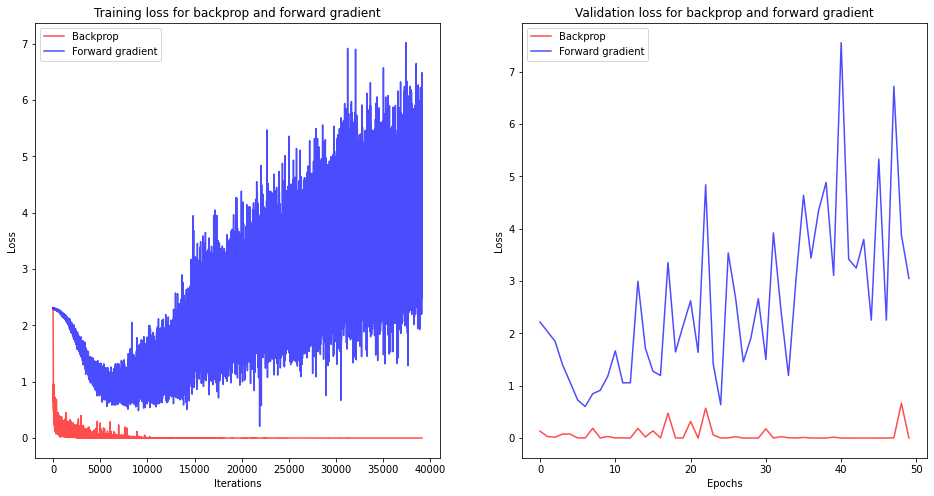

In [16]:
fig, ax = plt.subplots(1,2,figsize=(16,8))

ax[0].plot(losses, color='r', label="Backprop", alpha=.7)
ax[0].set_xlabel("Iterations")
ax[0].set_ylabel("Loss")
ax[0].plot(losses_fwd, color='b', label='Forward gradient', alpha=.7)
ax[0].set_title("Training loss for backprop and forward gradient")
ax[0].legend()

ax[1].plot(test_losses, color='r', label="Backprop", alpha=.7)
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
ax[1].plot(test_losses_fwd, color='b', label='Forward gradient', alpha=.7)
ax[1].set_title("Validation loss for backprop and forward gradient")
ax[1].legend()

# Convolutional Neural Network

We then use a CNN. Code can be found in `models.py`.

## SGD

### Learning rate optimization

The final search for learning rate is in a quite small interval as we earlier tried a wider search, but wanted to reduce the width to find a better optimum.

Searching for best learning rate and learning rate decay for forward gradient.

In [18]:
torch.manual_seed(42) # setting seed for reproducibility

# learning rate and decays grid search for forward gradient
learning_rates = np.logspace(-5, -3, 6)
decays = [1e-5, 1e-6]

epochs = 10

for gamma in learning_rates:
  for lambda_ in decays:
    net = ConvNet().to(device) # defining net

    # making the net functional to run the code in functorch
    # for evaluating the Jacobian-vector product
    func, params = ft.make_functional(net)

    # removing requires gradient as it will not be used
    # for the forward AD
    for param in params:
        param.requires_grad_(False)

    # defining our optimizer
    opt = ForwardSGD(func, functional_xent, params, lr=gamma, momentum = False, decay=lambda_)

    # training
    for e in range(epochs):
      for i, (image, label) in enumerate(train_data_loader):
        image, label = image.to(device), label.to(device)
        params, loss, jvp = opt.step(image, label) # one optimization step

    # evaluating on the val set
    test_losses = []
    for i, (image, label) in enumerate(val_data_loader):
      batch_loss = []
      with torch.no_grad():
        image, label = image.to(device), label.to(device)
        val_loss = functional_xent(params, func,image, label)
        batch_loss.append(val_loss.item())
      test_losses.append(np.mean(batch_loss))
    print(f"Validation loss for lr = {format(gamma,'.6f')}, decay = {format(lambda_,'.6f')}: {format(np.mean(test_losses),'.3f')}")

Validation loss for lr = 0.000010, decay = 0.000010: 2.303
Validation loss for lr = 0.000010, decay = 0.000001: 2.302
Validation loss for lr = 0.000025, decay = 0.000010: 2.302
Validation loss for lr = 0.000025, decay = 0.000001: 2.304
Validation loss for lr = 0.000063, decay = 0.000010: 2.301
Validation loss for lr = 0.000063, decay = 0.000001: 2.302
Validation loss for lr = 0.000158, decay = 0.000010: 2.301
Validation loss for lr = 0.000158, decay = 0.000001: 2.299
Validation loss for lr = 0.000398, decay = 0.000010: 2.275
Validation loss for lr = 0.000398, decay = 0.000001: 2.284
Validation loss for lr = 0.001000, decay = 0.000010: 14.432
Validation loss for lr = 0.001000, decay = 0.000001: 14.368


Searching for best learning rate and learning rate decay for backpropagation.

In [19]:
torch.manual_seed(42) # setting seed for reporducibility

# defining learning rates and decays for grid search
learning_rates = np.logspace(-3, -1, 6)
decays = [0]

criterion = nn.CrossEntropyLoss() # loss function
for gamma in learning_rates:
  for lambda_ in decays:
    lr_new = gamma
    net = ConvNet().to(device) # defining net

    # storing losses
    losses = []
    steps = 0
    for epoch in range(epochs):
      # going over training set in batches
      for i, (image, label) in enumerate(train_data_loader):
        steps += 1
        backprop = torch.optim.SGD(net.parameters(), lr=lr_new) # backprop SGD
        image, label = image.to(device), label.to(device)

        # optimizing
        backprop.zero_grad()
        outputs = net(image)
        loss = criterion(outputs, label)
        loss.backward()
        backprop.step()
        losses.append(loss.item())

        # learning rate decay
        lr_new = gamma * np.exp(-steps*lambda_)

    # evaluating on the val set
    test_losses = []
    for i, (image, label) in enumerate(val_data_loader):
      batch_loss = []
      with torch.no_grad():
        image, label = image.to(device), label.to(device)
        val_loss = criterion(net(image), label)
        batch_loss.append(val_loss.item())
      test_losses.append(np.mean(batch_loss))
    print(f"Validation loss for lr = {format(gamma,'.6f')}, decay = {format(lambda_,'.6f')}: {format(np.mean(test_losses),'.3f')}")

Validation loss for lr = 0.001000, decay = 0.000000: 0.447
Validation loss for lr = 0.002512, decay = 0.000000: 0.199
Validation loss for lr = 0.006310, decay = 0.000000: 0.060
Validation loss for lr = 0.015849, decay = 0.000000: 0.049
Validation loss for lr = 0.039811, decay = 0.000000: 0.091
Validation loss for lr = 0.100000, decay = 0.000000: 0.041


### Modeling

We first run forward gradient for the optimal hyperparameters.

In [20]:
torch.manual_seed(42) # setting seed for reproducibility

net = ConvNet().to(device) # defining net

# using best lr and decay found in the optimizations below
lr = 0.000398
decay = 1e-5
# making the net functional to run the code in functorch
# for evaluating the Jacobian-vector product
func, params = ft.make_functional(net)

# removing requires gradient as it will not be used
# for the forward AD
for param in params:
    param.requires_grad_(False)

# defining our optimizer
opt = ForwardSGD(func, functional_xent, params, lr=lr, momentum = False, decay=decay, clip = 1)

# training for e epochs
losses_fwd = []
norms = []
epochs = 50
test_losses_fwd = []
for e in range(epochs):
  for j, (image, label) in enumerate(train_data_loader):
    image, label = image.to(device), label.to(device)
    params, loss, norm = opt.step(image, label)
    try:
      norms.append(norm.item())
    except:
      norms.append(norm)
    losses_fwd.append(loss.item())

  # evaluating on the test set
  for i, (image, label) in enumerate(test_data_loader):
    with torch.no_grad():
      batch_loss = []
      image, label = image.to(device), label.to(device)
      test_loss = functional_xent(params, func, image, label)
      batch_loss.append(test_loss.item())
  test_losses_fwd.append(np.mean(batch_loss))
  print(f"Test loss in epoch {e+1}: {format(test_losses_fwd[-1], '.3f')}")


Test loss in epoch 1: 2.296
Test loss in epoch 2: 2.298
Test loss in epoch 3: 2.298
Test loss in epoch 4: 2.298
Test loss in epoch 5: 2.299
Test loss in epoch 6: 2.296
Test loss in epoch 7: 2.294
Test loss in epoch 8: 2.290
Test loss in epoch 9: 2.297
Test loss in epoch 10: 2.299
Test loss in epoch 11: 2.291
Test loss in epoch 12: 2.289
Test loss in epoch 13: 2.273
Test loss in epoch 14: 2.262
Test loss in epoch 15: 2.251
Test loss in epoch 16: 2.196
Test loss in epoch 17: 2.184
Test loss in epoch 18: 2.132
Test loss in epoch 19: 2.043
Test loss in epoch 20: 1.838
Test loss in epoch 21: 1.700
Test loss in epoch 22: 1.619
Test loss in epoch 23: 1.237
Test loss in epoch 24: 1.109
Test loss in epoch 25: 1.153
Test loss in epoch 26: 0.922
Test loss in epoch 27: 0.729
Test loss in epoch 28: 0.846
Test loss in epoch 29: 0.675
Test loss in epoch 30: 0.783
Test loss in epoch 31: 0.747
Test loss in epoch 32: 0.655
Test loss in epoch 33: 0.787
Test loss in epoch 34: 0.661
Test loss in epoch 35: 

Backpropagation:

In [21]:
torch.manual_seed(42) # setting seed for reproducibility

lr = 0.1
decay = 0
epochs = 50
lr_new = lr
criterion = nn.CrossEntropyLoss() # loss function
net = ConvNet().to(device) # defining net

# storing losses
losses = []
test_losses = []
steps = 0
for e in range(epochs):
  # going over training set in batches
  for i, (image, label) in enumerate(train_data_loader):
    steps += 1
    backprop = torch.optim.SGD(net.parameters(), lr=lr_new) # normal SGD in torch
    image, label = image.to(device), label.to(device)
    backprop.zero_grad()
    outputs = net(image)
    loss = criterion(outputs, label)
    loss.backward()
    backprop.step()
    losses.append(loss.item())
    lr_new = lr * np.exp(-steps*decay)
  
  # testing on test set
  for i, (image, label) in enumerate(test_data_loader):
    with torch.no_grad():
      batch_loss = []
      image, label = image.to(device), label.to(device)
      test_loss = criterion(net(image), label)
      batch_loss.append(test_loss.item())
  test_losses.append(np.mean(batch_loss))
  print(f"Test loss in epoch {e+1}: {(test_losses[-1])}")

Test loss in epoch 1: 0.011456367559731007
Test loss in epoch 2: 0.000898439553566277
Test loss in epoch 3: 0.08411397784948349
Test loss in epoch 4: 0.07168854027986526
Test loss in epoch 5: 0.0018400436965748668
Test loss in epoch 6: 0.00031653069891035557
Test loss in epoch 7: 0.0018646365497261286
Test loss in epoch 8: 3.0781575333094224e-05
Test loss in epoch 9: 0.0026352398563176394
Test loss in epoch 10: 1.7440714145777747e-05
Test loss in epoch 11: 0.057991791516542435
Test loss in epoch 12: 1.3655467228090856e-05
Test loss in epoch 13: 1.4901159417490817e-08
Test loss in epoch 14: 9.102375770453364e-05
Test loss in epoch 15: 9.39462915994227e-06
Test loss in epoch 16: 3.9487952108174795e-07
Test loss in epoch 17: 4.650418122764677e-05
Test loss in epoch 18: 0.00023462824174202979
Test loss in epoch 19: 0.009191622026264668
Test loss in epoch 20: 9.23866139146412e-07
Test loss in epoch 21: 6.857820699224249e-05
Test loss in epoch 22: 2.7864550702361157e-06
Test loss in epoch 23

#### Comparing results

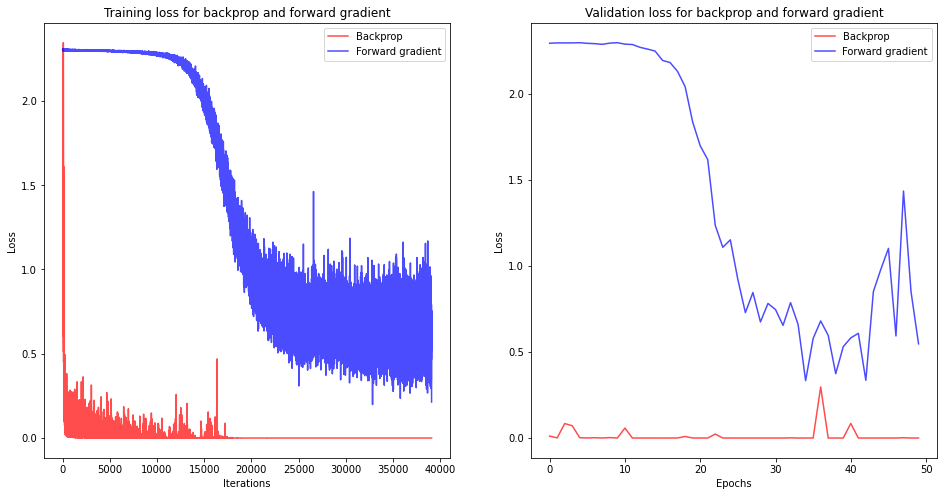

In [22]:
fig, ax = plt.subplots(1,2,figsize=(16,8))

ax[0].plot(losses, color='r', label="Backprop", alpha=.7)
ax[0].set_xlabel("Iterations")
ax[0].set_ylabel("Loss")
ax[0].plot(losses_fwd[:], color='b', label='Forward gradient', alpha=.7)
ax[0].set_title("Training loss for backprop and forward gradient")
ax[0].legend()

ax[1].plot(test_losses, color='r', label="Backprop", alpha=.7)
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
ax[1].plot(test_losses_fwd, color='b', label='Forward gradient', alpha=.7)
ax[1].set_title("Validation loss for backprop and forward gradient")
ax[1].legend()

## SGD with Nesterov momentum

We now incorporate SGD with Nesterov momentum.

### Learning rate optimization

The final search for learning rate is in a quite small interval as we earlier tried a wider search, but wanted to reduce the width to find a better optimum.

Searching for best learning rate and momentum for forward gradient.

In [17]:
torch.manual_seed(42) # setting seed for reproducibility

# learning rate and momentum grid search for forward gradient
learning_rates = np.logspace(-5, -3, 4)
momentums = np.linspace(0.1, 0.9, 4)

epochs = 10

for gamma in learning_rates:
  for momentum in momentums:
    net = ConvNet().to(device) # defining net

    # making the net functional to run the code in functorch
    # for evaluating the Jacobian-vector product
    func, params = ft.make_functional(net)

    # removing requires gradient as it will not be used
    # for the forward AD
    for param in params:
        param.requires_grad_(False)

    # defining our optimizer
    opt = ForwardSGD(func, functional_xent, params, lr=gamma,
                     momentum = momentum, nesterov = True, decay=1e-4, clip=1)

    # training
    for e in range(epochs):
      for i, (image, label) in enumerate(train_data_loader):
        image, label = image.to(device), label.to(device)
        params, loss, jvp = opt.step(image, label) # one optimization step

    # evaluating on the val set
    test_losses = []
    for i, (image, label) in enumerate(val_data_loader):
      batch_loss = []
      with torch.no_grad():
        image, label = image.to(device), label.to(device)
        val_loss = functional_xent(params, func,image, label)
        batch_loss.append(val_loss.item())
      test_losses.append(np.mean(batch_loss))
    print(f"Validation loss for lr = {format(gamma,'.6f')}, Momentum = {format(momentum,'.6f')}: {format(np.mean(test_losses),'.3f')}")

Validation loss for lr = 0.000010, Momentum = 0.100000: 2.303
Validation loss for lr = 0.000010, Momentum = 0.366667: 2.302
Validation loss for lr = 0.000010, Momentum = 0.633333: 2.302
Validation loss for lr = 0.000010, Momentum = 0.900000: 2.303
Validation loss for lr = 0.000046, Momentum = 0.100000: 2.301
Validation loss for lr = 0.000046, Momentum = 0.366667: 2.302
Validation loss for lr = 0.000046, Momentum = 0.633333: 2.301
Validation loss for lr = 0.000046, Momentum = 0.900000: 2.272
Validation loss for lr = 0.000215, Momentum = 0.100000: 2.294
Validation loss for lr = 0.000215, Momentum = 0.366667: 2.289
Validation loss for lr = 0.000215, Momentum = 0.633333: 2.226
Validation loss for lr = 0.000215, Momentum = 0.900000: 10.599
Validation loss for lr = 0.001000, Momentum = 0.100000: 1.637
Validation loss for lr = 0.001000, Momentum = 0.366667: 5.886
Validation loss for lr = 0.001000, Momentum = 0.633333: 10.869
Validation loss for lr = 0.001000, Momentum = 0.900000: 11.780


Searching for best learning rate and momentum for backpropagation.

In [8]:
torch.manual_seed(42) # setting seed for reporducibility

# defining learning rates and decays for grid search
learning_rates = np.logspace(-2, -1, 3)
momentums = np.linspace(0.7, 0.95, 4)

criterion = nn.CrossEntropyLoss() # loss function
for gamma in learning_rates:
  for momentum in momentums:
    net = ConvNet().to(device) # defining net
    backprop = torch.optim.SGD(net.parameters(), lr=gamma,
                                   momentum = momentum, nesterov = True) # backprop SGD
    # storing losses
    losses = []
    for epoch in range(epochs):
      # going over training set in batches
      for i, (image, label) in enumerate(train_data_loader):
        image, label = image.to(device), label.to(device)

        # optimizing
        backprop.zero_grad()
        outputs = net(image)
        loss = criterion(outputs, label)
        loss.backward()
        backprop.step()
        losses.append(loss.item())

    # evaluating on the val set
    test_losses = []
    for i, (image, label) in enumerate(val_data_loader):
      batch_loss = []
      with torch.no_grad():
        image, label = image.to(device), label.to(device)
        val_loss = criterion(net(image), label)
        batch_loss.append(val_loss.item())
      test_losses.append(np.mean(batch_loss))
    print(f"Validation loss for lr = {format(gamma,'.6f')}, Momentum = {format(momentum,'.6f')}: {format(np.mean(test_losses),'.3f')}")

Validation loss for lr = 0.010000, Momentum = 0.700000: 0.065
Validation loss for lr = 0.010000, Momentum = 0.783333: 0.038
Validation loss for lr = 0.010000, Momentum = 0.866667: 0.039
Validation loss for lr = 0.010000, Momentum = 0.950000: 0.067
Validation loss for lr = 0.031623, Momentum = 0.700000: 0.047
Validation loss for lr = 0.031623, Momentum = 0.783333: 0.044
Validation loss for lr = 0.031623, Momentum = 0.866667: 0.040
Validation loss for lr = 0.031623, Momentum = 0.950000: 0.067
Validation loss for lr = 0.100000, Momentum = 0.700000: 0.039
Validation loss for lr = 0.100000, Momentum = 0.783333: 0.033
Validation loss for lr = 0.100000, Momentum = 0.866667: 2.305
Validation loss for lr = 0.100000, Momentum = 0.950000: 2.309


### Modeling

We first run forward gradient for the optimal hyperparameters.

In [18]:
# for reproducible purposes
torch.manual_seed(42)

net = ConvNet().to(device) # defining net

# using best lr and decay found in the optimizations below
lr = 0.001000
momentum = 1.637
# making the net functional to run the code in functorch
# for evaluating the Jacobian-vector product
func, params = ft.make_functional(net)

# removing requires gradient as it will not be used
# for the forward AD
for param in params:
    param.requires_grad_(False)

# defining our optimizer
opt = ForwardSGD(func, functional_xent, params, lr=lr, momentum = momentum, nesterov = True, clip = 1)

# running the code for e epochs
losses_fwd = []
epochs = 25
test_losses_fwd = []
for e in range(epochs):
  # training
  for j, (image, label) in enumerate(train_data_loader):
    image, label = image.to(device), label.to(device)
    params, loss, jvp = opt.step(image, label)
    losses_fwd.append(loss.item())
  # evaluating on the test set
  for i, (image, label) in enumerate(test_data_loader):
    with torch.no_grad():
      batch_loss = []
      image, label = image.to(device), label.to(device)
      test_loss = functional_xent(params, func, image, label)
      batch_loss.append(test_loss.item())
  test_losses_fwd.append(np.mean(batch_loss))
  print(f"Test loss in epoch {e+1}: {(test_losses_fwd[-1])}")


Test loss in epoch 1: nan
Test loss in epoch 2: nan
Test loss in epoch 3: nan
Test loss in epoch 4: nan
Test loss in epoch 5: nan
Test loss in epoch 6: nan
Test loss in epoch 7: nan
Test loss in epoch 8: nan
Test loss in epoch 9: nan
Test loss in epoch 10: nan
Test loss in epoch 11: nan
Test loss in epoch 12: nan
Test loss in epoch 13: nan
Test loss in epoch 14: nan
Test loss in epoch 15: nan
Test loss in epoch 16: nan
Test loss in epoch 17: nan
Test loss in epoch 18: nan
Test loss in epoch 19: nan
Test loss in epoch 20: nan
Test loss in epoch 21: nan
Test loss in epoch 22: nan
Test loss in epoch 23: nan
Test loss in epoch 24: nan
Test loss in epoch 25: nan


Backpropagation:

In [19]:
torch.manual_seed(42) # setting seed for reproducibility

lr = 0.010000
momentum = 0.783
epochs = 50
lr_new = lr
criterion = nn.CrossEntropyLoss() # loss function
net = ConvNet().to(device) # defining net
backprop = torch.optim.SGD(net.parameters(), lr=lr_new,
                               momentum = momentum, nesterov = True) # normal SGD in torch

# storing losses
losses = []
test_losses = []
for e in range(epochs):
  # going over training set in batches
  for i, (image, label) in enumerate(train_data_loader):
    image, label = image.to(device), label.to(device)
    backprop.zero_grad()
    outputs = net(image)
    loss = criterion(outputs, label)
    loss.backward()
    backprop.step()
    losses.append(loss.item())
  
  # testing on test set
  for i, (image, label) in enumerate(test_data_loader):
    with torch.no_grad():
      batch_loss = []
      image, label = image.to(device), label.to(device)
      test_loss = criterion(net(image), label)
      batch_loss.append(test_loss.item())
  test_losses.append(np.mean(batch_loss))
  print(f"Test loss in epoch {e+1}: {(test_losses[-1])}")

Test loss in epoch 1: 0.015787575393915176
Test loss in epoch 2: 0.0021923540625721216
Test loss in epoch 3: 0.012933120131492615
Test loss in epoch 4: 0.0043885838240385056
Test loss in epoch 5: 0.018080079928040504
Test loss in epoch 6: 0.001556247123517096
Test loss in epoch 7: 0.02679319493472576
Test loss in epoch 8: 0.0007720048888586462
Test loss in epoch 9: 0.0035625125747174025
Test loss in epoch 10: 0.0015093664405867457
Test loss in epoch 11: 0.1028296947479248
Test loss in epoch 12: 1.1324813158353209e-06
Test loss in epoch 13: 4.7683133743703365e-06
Test loss in epoch 14: 4.573308979161084e-05
Test loss in epoch 15: 7.538141653640196e-05
Test loss in epoch 16: 1.3411033705779118e-07
Test loss in epoch 17: 0.005310583859682083
Test loss in epoch 18: 5.401881935540587e-05
Test loss in epoch 19: 0.039031077176332474
Test loss in epoch 20: 6.201769429026172e-05
Test loss in epoch 21: 6.243384632398374e-06
Test loss in epoch 22: 1.0675915291358251e-05
Test loss in epoch 23: 0.0

#### Comparing results

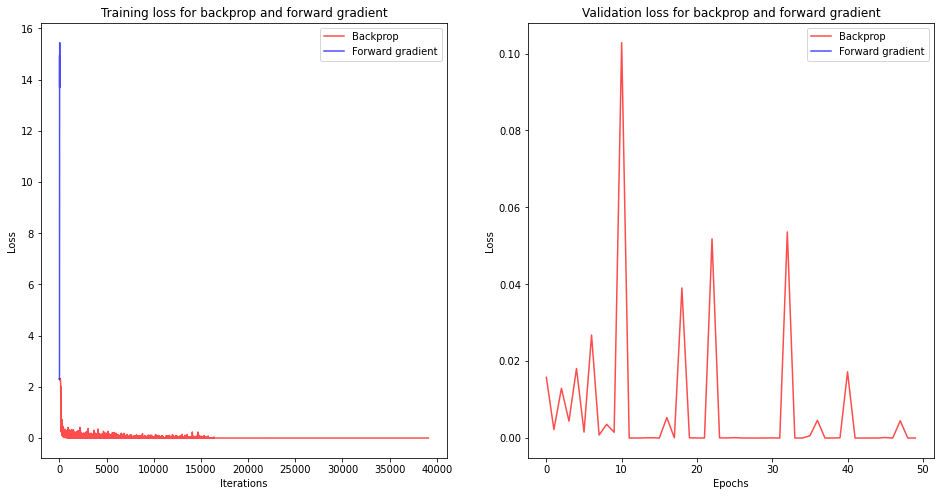

In [20]:
fig, ax = plt.subplots(1,2,figsize=(16,8))

ax[0].plot(losses, color='r', label="Backprop", alpha=.7)
ax[0].set_xlabel("Iterations")
ax[0].set_ylabel("Loss")
ax[0].plot(losses_fwd[:], color='b', label='Forward gradient', alpha=.7)
ax[0].set_title("Training loss for backprop and forward gradient")
ax[0].legend()

ax[1].plot(test_losses, color='r', label="Backprop", alpha=.7)
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
ax[1].plot(test_losses_fwd, color='b', label='Forward gradient', alpha=.7)
ax[1].set_title("Validation loss for backprop and forward gradient")
ax[1].legend()